In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# 1. Introduction

[In this blog post by Andrew Gelman](https://statmodeling.stat.columbia.edu/2020/05/18/hey-i-think-somethings-wrong-with-this-graph/), the author asks how a visual deceptive graph could be created by genuine mistake. The incriminated graph shows (what I assume) is the daily new cases of COVID-19 in the top 5 counties with most cases in the state of Georgia, US.

The graph is deceptive because:

1. The dates (x-axis) are not chronologically ordered;
2. Each group of bars (the counties) are not ordered in the same way for each day;
3. Time based comparison is usually more effective with a line plot.

# 2. Goal

In this note I show how a simple error, namely a particular sorting of the data, could lead to the same result.

**Notice**. I've not been able to find the data underlying the original graph. I've used New York Times data opnly available in [github](https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv).

## 2.1. A somewhat strong assumption

I assume that the authors of the graph were using some low level functionality of their preferred data visualization tool. In my case, I will use matplotlib trying to get in the shoes of a 10 year younger version of myself, when I would have looped over the data, instead of searching for the best tool.

In [2]:
DATA_URL = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
COUNTY_ORDER = ['Cobb', 'DeKalb', 'Fulton', 'Gwinnett', 'Hall']
DATE_START = '2020-04-26'
DATE_END = '2020-05-09'

In [3]:
georgia_df = (
    pd.read_csv(DATA_URL)
    .query('state=="Georgia"')
    .query('county in @COUNTY_ORDER')
    .assign(date=lambda df: pd.to_datetime(df.date))
    .sort_values(['date', 'county'])
    .assign(daily_new_cases=lambda df: df.groupby('county')['cases'].transform(lambda x: x.diff()))
    .assign(date_volume=lambda df: df.groupby('date').daily_new_cases.transform('sum'))
    .query('date >= @DATE_START')
    .query('date <= @DATE_END')
    .reset_index(drop=True)
)

In [4]:
TITLE = 'Top 5 Counties with the Greatest Number of Confirmed COVID-19 cases'
SUBTITLE = '''
The chart below represents the most impacted counties over the period [{s:%b-%d}, {e:%b-%d}]
and the number of cases over time.
'''.format(s=pd.to_datetime(DATE_START), e=pd.to_datetime(DATE_END)).strip()

# 3. Replicate "bad" graph
## 3.1 Plot utilities

To re-create the graph mentioned in the blog post I had to remember my first data science days, when I had very little knowledge of python and matplotlib.

In order to create a bar plot to show different groups (in this case the counties) for a given category (the date) the trick is to iterate over the groups, create a bar plot by shift each bar a bit.

In old times, this function would have been saved in a `viz_snippet.py` and re-used when needed (perhaps incurring in the same mistakes I am showing in this post).

In [5]:
BAR_WIDTH = .6
SEPARATOR_WIDTH = 2
MAX_Y_AXIS = georgia_df.daily_new_cases.max() * 1.04

In [6]:
def get_coords_to_plot(
    data, x_col, y_col,
    counties=COUNTY_ORDER, bar_width=BAR_WIDTH, separator_width=SEPARATOR_WIDTH
):
    '''Get per county dictionary with x-values/y-values.
    For each x-value record the date and the x-location where to set the x-tick.

    Assume the dataframe sorting has counties in sequential order (e.g. [abc, cba, bca] and not [aabc..])
    '''
    # There are 5 counties - so initialiase with 5 empty arrays
    # Notice that `dict(zip(counties, [[]] * len(counties)))` would not work! (Exercise: why?)
    x_vals = dict(zip(counties, [[], [], [], [], []]))
    y_vals = dict(zip(counties, [[], [], [], [], []]))
    date_vals = []
    xticks_coords = []
    x = 0
    cntr = 0
    for _, row in data.iterrows():
        x_vals[row.county].append(x)
        y_vals[row.county].append(row[y_col])
        if cntr % len(counties) == len(counties) - 1:
            # Arrived at end of the group, leave more space
            x += separator_width
            date_vals.append(row[x_col].strftime('%b-%d'))
        if cntr % len(counties) == int(len(counties)/2):
            # Arrived in the middle of the group, x-ticks will go here
            xticks_coords.append(x)
        x += bar_width
        cntr += 1
    return x_vals, y_vals, date_vals, xticks_coords

## 3.2 Original graph, or how not to make a visualization

What I believe was the main oversight of the graph showed in the [blog post](https://statmodeling.stat.columbia.edu/2020/05/18/hey-i-think-somethings-wrong-with-this-graph/), was the usage of a flexible plotting function that would iterate on the rows of the data by providing data sorted in the wrong way.

To replicate the graph, it is enough to use the function `get_coords_to_plot` and plot the data via [matplotlib bar-plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html) by sorting the data on the columns `date_volume', 'daily_new_cases` (instead of `date, county`).

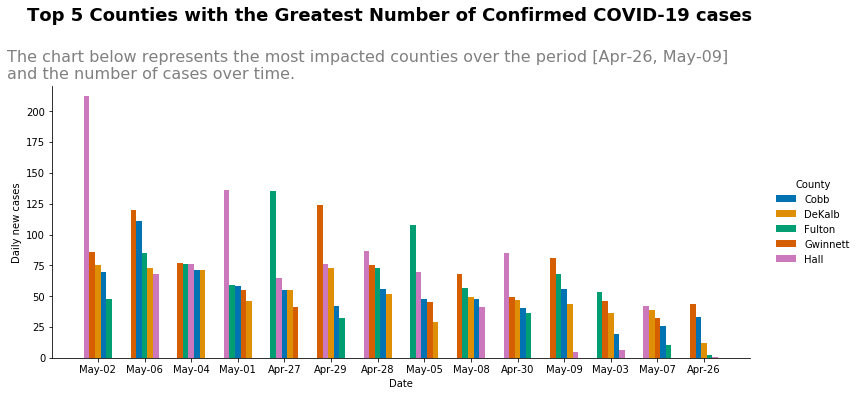

In [7]:
x_vals, y_vals, date_vals, xticks_coords = get_coords_to_plot(
    data=georgia_df.sort_values(['date_volume', 'daily_new_cases'], ascending=False),
    x_col='date',
    y_col='daily_new_cases',
)

county_colors = dict(zip(COUNTY_ORDER, sns.color_palette('colorblind', n_colors=len(COUNTY_ORDER))))

fig, ax = plt.subplots(figsize=(5 * 2.5, 5))
# Plot
for county in COUNTY_ORDER:
    ax.bar(x_vals[county], y_vals[county], width=BAR_WIDTH, color=county_colors[county], label=county)
# Customize
ax.legend(bbox_to_anchor=(1.025, .5), loc='center left', frameon=False, title='County')
ax.set_ylim(0, MAX_Y_AXIS)
ax.set_xticks(xticks_coords)
ax.set_xlabel('Date')
ax.set_ylabel('Daily new cases')
ax.set_xticklabels(date_vals)
fig.suptitle(TITLE, y=1.1, fontsize=18, fontweight='bold')
fig.text(0.075, .9, SUBTITLE, color='grey', fontsize=16)
sns.despine();

## 3.3 Original graph, fixed

The same few lines of code with the right sorting (by `date, county`) would bring a less misleading visualization.

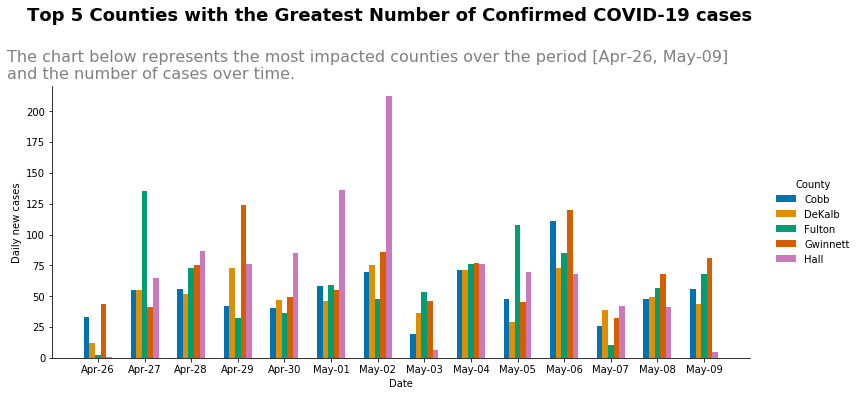

In [8]:
x_vals, y_vals, date_vals, xticks_coords = get_coords_to_plot(
    data=georgia_df.sort_values(['date', 'county']),
    x_col='date',
    y_col='daily_new_cases'
)
# Plot
fig, ax = plt.subplots(figsize=(5 * 2.5, 5))
for county in COUNTY_ORDER:
    ax.bar(
        x_vals[county], y_vals[county],
        # marker='o',
        width=BAR_WIDTH,
        color=county_colors[county], label=county
    )
# Customize
ax.legend(bbox_to_anchor=(1.025, .5), loc='center left', frameon=False, title='County')
ax.set_ylim(0, MAX_Y_AXIS)
ax.set_xticks(xticks_coords)
ax.set_xticklabels(date_vals)
ax.set_xlabel('Date')
ax.set_ylabel('Daily new cases')

fig.suptitle(TITLE, y=1.1, fontsize=18, fontweight='bold')
fig.text(0.075, .9, SUBTITLE, color='grey', fontsize=16)
sns.despine();

# 4. Simpler way: seaborn

[Seaborn](https://seaborn.pydata.org) is a python library for data visualization. It is based on `matplotlib`.

Using seaborn [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot), no matter how the data is sorted, will yield the right time order on the x-axis. In addition, passing the list of counties as `hue_order` parameter, we can assure that the order in the legend is as expected.

### 4.1 Daily trend shown via a line-plot

In this case we wrap the line-plot function in a `FacetGrid` object ([docs here](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html?highlight=facetgrid#seaborn.FacetGrid)). This is to take advantage of some built-in customizations that make the plot and the legend prettier.

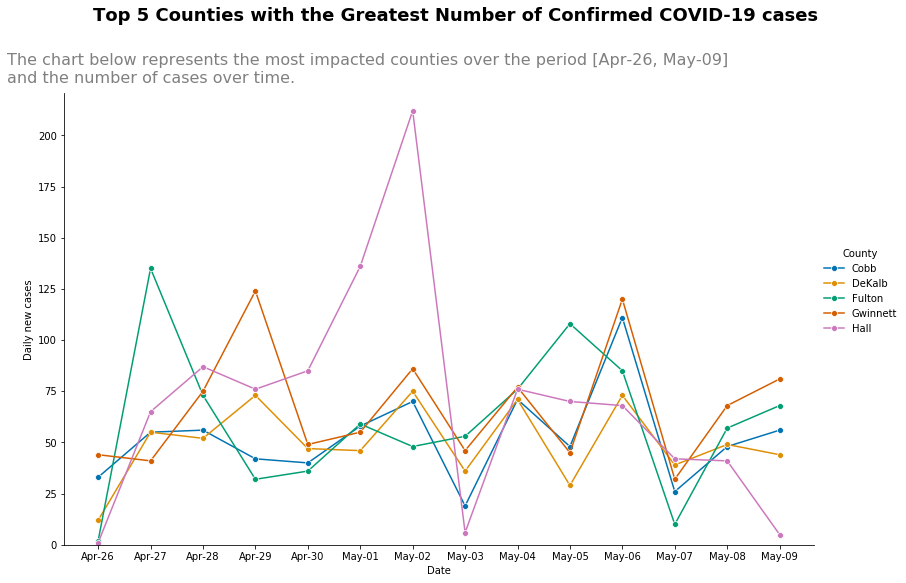

In [9]:
g = sns.FacetGrid(
    data=georgia_df.sort_values('date_volume'), hue='county', hue_order=COUNTY_ORDER,
    palette='colorblind', height=7, aspect=1.618
)
g.map(sns.lineplot, 'date', 'daily_new_cases', marker='o')
g.add_legend(title='County')

x_date_range = pd.date_range(DATE_START, DATE_END)
g.set(xticks=x_date_range, xticklabels=x_date_range.map(lambda x: x.strftime('%b-%d')), ylim=(0, MAX_Y_AXIS))
g.set_axis_labels(x_var='Date', y_var='Daily new cases')

g.fig.suptitle(TITLE, y=1.15, fontsize=18, fontweight='bold')
g.fig.text(0, 1, SUBTITLE, color='grey', fontsize=16);

### 4.1 Seaborn pitfall: treating time as category may lead to un-ordered time

The seaborn way to plot categorical data in a `FacetGrid` fashion is by using `catplot`, which creates a `FacetGrid` object.

In our case, this feature will treat the dates as categorical (read: without natural ordering). Hence, **if the order of the dates in the given dataframe is not the natural ordering, the rendered graph will be misleading**.

An example is given below, where we order the dates by days with most total new cases.

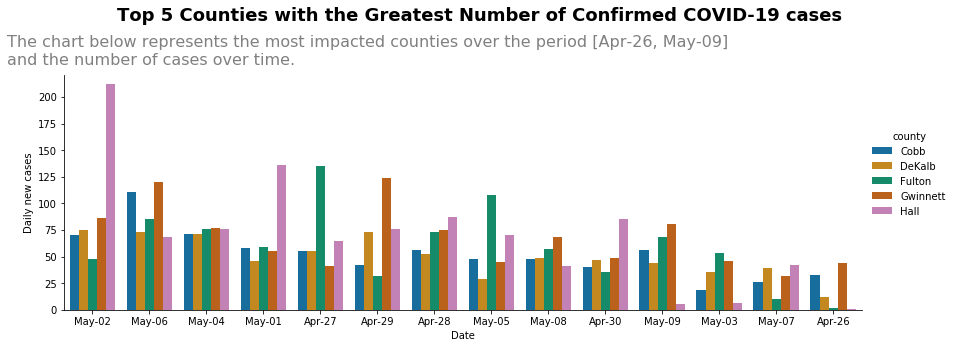

In [10]:
g = sns.catplot(
    x='date_str', y='daily_new_cases',
    # The right way to show this graph would be to sort by `date`
    data=georgia_df.sort_values('date_volume', ascending=False).assign(date_str=lambda x: x.date.dt.strftime('%b-%d')),
    hue='county', hue_order=COUNTY_ORDER,
    palette='colorblind', kind='bar', height=4, aspect=3
)
g.set(ylim=(0, MAX_Y_AXIS))
g.set_axis_labels(x_var='Date', y_var='Daily new cases')
g.fig.suptitle(TITLE, y=1.2, fontsize=18, fontweight='bold')
g.fig.text(0, 1, SUBTITLE, color='grey', fontsize=16);